Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам
ксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [54]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [55]:
import pandas as pd
data = pd.read_excel('C:/Users/User/Downloads/AB_Test_Results.xlsx')
data.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [57]:
data.shape

(10000, 3)

In [58]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [59]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [60]:
double = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')
double

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [61]:
data = data.sort_values('USER_ID')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
2406,2,control,0.0
3479,2,control,0.0
7076,2,control,0.0
7409,3,variant,0.0
4145,3,variant,0.0
5377,3,control,0.0
9077,4,variant,0.0
9155,5,variant,0.0
7720,6,variant,0.0
3920,9,variant,0.0


In [62]:
data = data[~data['USER_ID'].isin(double['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
data

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
...,...,...,...
6065,9992,control,0.0
6066,9993,control,0.0
6067,9995,variant,0.0
6068,9995,variant,0.0


In [63]:
data.duplicated().sum()

1249

In [64]:
data = data.drop_duplicates().reset_index(drop=True)
data

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4816,9990,variant,0.0
4817,9992,control,0.0
4818,9993,control,0.0
4819,9995,variant,0.0


Необходимо обратить внимание на разделение трафика

In [65]:
data.describe()

,USER_ID,REVENUE
count,4821.000000,4821.000000
mean,4990.971375,0.134802
std,2901.241677,2.999336
min,2.000000,0.000000
25%,2469.000000,0.000000
50%,4969.000000,0.000000
75%,7518.000000,0.000000
max,9998.000000,196.010000


In [66]:
data['VARIANT_NAME'].value_counts()

control    2414
variant    2407
Name: VARIANT_NAME, dtype: int64

In [67]:
data[data['REVENUE'] > 0]

,USER_ID,VARIANT_NAME,REVENUE
27,56,variant,2.99
62,124,control,1.25
84,169,control,4.33
140,282,control,18.56
213,443,variant,3.75
...,...,...,...
4482,9317,variant,2.27
4563,9491,control,2.34
4579,9520,variant,5.08
4711,9766,control,3.79


In [68]:
data['REVENUE'].describe()

count    4821.000000
mean        0.134802
std         2.999336
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

In [69]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,2414.000000,2414.000000
mean,5013.042254,0.194930
std,2908.727995,4.151447
min,2.000000,0.000000
25%,2495.500000,0.000000
50%,5008.500000,0.000000
75%,7613.000000,0.000000
max,9998.000000,196.010000


In [70]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,2407.000000,2407.000000
mean,4968.836311,0.074499
std,2894.149437,0.854413
min,4.000000,0.000000
25%,2437.000000,0.000000
50%,4951.000000,0.000000
75%,7383.000000,0.000000
max,9995.000000,23.040000


In [71]:
data['Conversion'] = data['REVENUE'].apply(lambda x: int(x>0))
data.pivot_table(index='VARIANT_NAME',
               columns='Conversion',
               values='USER_ID',
               aggfunc='count',
               margins=True)

Conversion,0,1,All
VARIANT_NAME,,,
control,2360,54,2414
variant,2364,43,2407
All,4724,97,4821


Наблюдаются лучшие данные у контрольной группы

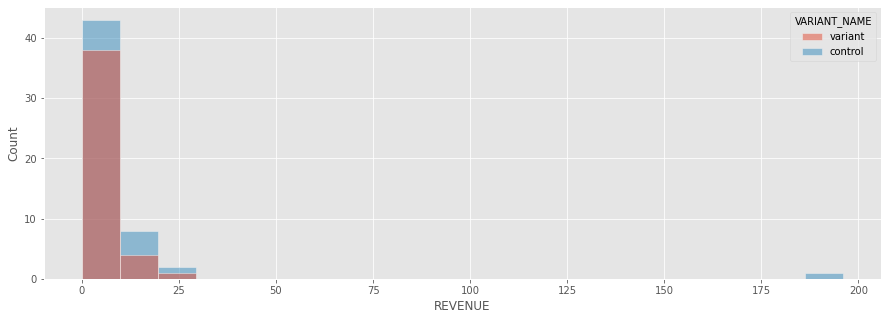

In [72]:
plt.figure(figsize=(15, 5))
sns.histplot(data[data['Conversion']==1], x='REVENUE', bins=20, hue='VARIANT_NAME');

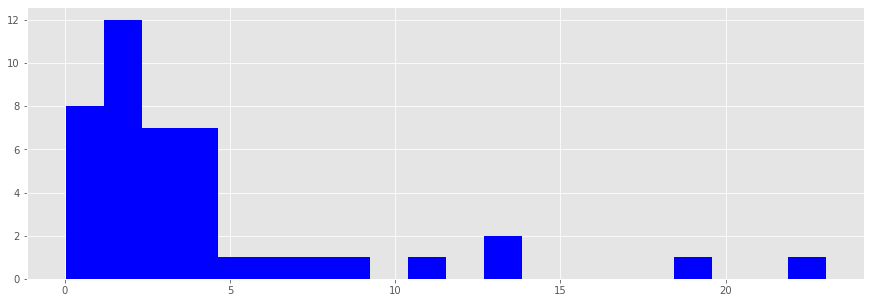

In [75]:
plt.figure(figsize=(15, 5))
Rcontrol = data['REVENUE'][(data['VARIANT_NAME'] == 'controle')&(data['REVENUE'] > 0)]
Rvariant =data['REVENUE'][(data['VARIANT_NAME'] == 'variant')&(data['REVENUE'] > 0)]
plt.hist(Rvariant, color='b', bins=20)
plt.hist(Rcontrol, color='r', bins=20)

plt.show()

In [76]:
Cgroup = data.query('VARIANT_NAME == "control"')
Vgroup = data.query('VARIANT_NAME == "variant"')
n1 = Cgroup.shape[0]
n2 = Vgroup.shape[0]
m1 = Cgroup[Cgroup['Conversion']==1].shape[0]
m2 = Vgroup[Vgroup['Conversion']==1].shape[0]
p1 = m1 / n1
p2 = m2 / n2
p1, p2

(0.02236951118475559, 0.017864561695056087)

In [77]:
alpha = 0.05
pvalue = stats.shapiro(data['REVENUE'])[1]
print('Distribution is ' + ['','not'][pvalue < alpha] + ' normal')

Distribution is not normal


Ненормальное распределение, данных мало, и есть выбросы.

In [78]:
data.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,2414.0,0.194930,4.151447,0.0,0.0,0.0,0.0,196.01
variant,2407.0,0.074499,0.854413,0.0,0.0,0.0,0.0,23.04


In [79]:
mw_stats = stats.mannwhitneyu(x=data[(data['VARIANT_NAME'] == 'control')]['REVENUE'].values,
                              y=data[(data['VARIANT_NAME'] == 'variant')]['REVENUE'].values)
mw_stats
#ARPU

MannwhitneyuResult(statistic=2918468.0, pvalue=0.26069244720791673)

pvalue больше 0,05, т.е. статистически значимая разница между группами отсутствует.

Гипотезы:

H0: Набор статистически значимо не влияет (p-value > 0.05)

H1: Набор статистически значимо влияет (p-value < 0.05)

In [80]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1),
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            len(data_column_1),
            replace = True
        ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

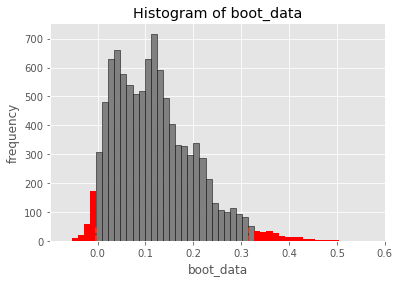

{'p_value': 0.16627664388244168}

In [81]:
get_bootstrap(data[(data['VARIANT_NAME'] == 'control')]['REVENUE'], data[(data['VARIANT_NAME'] == 'variant')]['REVENUE'])

-->>> H0: Набор статистически значимо не влияет (p-value > 0.05)

In [51]:
from math import sqrt
from statsmodels.stats.power import TTestIndPower

In [82]:
M1 = Cgroup['REVENUE'].mean()
M2 = Vgroup['REVENUE'].mean()
D1 = Cgroup['REVENUE'].var()
D2 = Vgroup['REVENUE'].var()
effect_size = (M1-M2)/np.sqrt(((n1-1)*D1 + (n2-1)*D2)/(n1+n2-2))
effect_size

0.04015622200080912

In [84]:
analysis = TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=0.05, power=None, nobs1=n1, ratio=n2/n1)

0.28604403832811304

In [ ]:
Небольшая мощность теста. т.к. данных мало. 

In [ ]:
Можно предположить нарушение сроков эсперимента. Предлагаю проверить дизайн теста, расчет времени его проведения и повторить
в строгом соответсвии с планом.